## Exploratory Data Analysis 
*This file was written by Nicole and reformatted by Jack.*

This `.ipynb` file examines the raw data, and was used to inform the `PreProcessing Pipeline` class in `data/preprocess_data.py`. We begin by importing the necessary libraries.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")

We read in the `data.parquet` and `labels.parquet` files, encode the specific cancer labels numerically with the `encoding_dict` specified in the `README.md` file, and merge the two datasets together.

In [2]:
data = pd.read_parquet('./data/data.parquet')
labels = pd.read_parquet('./data/labels.parquet')

encoding_dict = {
    'BRCA': 0,
    'KIRC': 1,
    'COAD': 2,
    'LUAD': 3,
    'PRAD': 4
}

labels['Class'] = labels['Class'].map(encoding_dict)

data.rename(columns={'Unnamed: 0': 'sample_id'}, inplace=True)
labels.rename(columns={'Unnamed: 0': 'sample_id'}, inplace=True)

merged_data = pd.merge(labels, data, on='sample_id')
data = data.drop(columns=['sample_id'])
labels = labels.drop(columns=['sample_id'])

merged_data.head()

,sample_id,Class,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,4,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,3,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,4,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,4,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,0,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


We examine the size of the activations across subjects for all genes tested (the sum of each column).

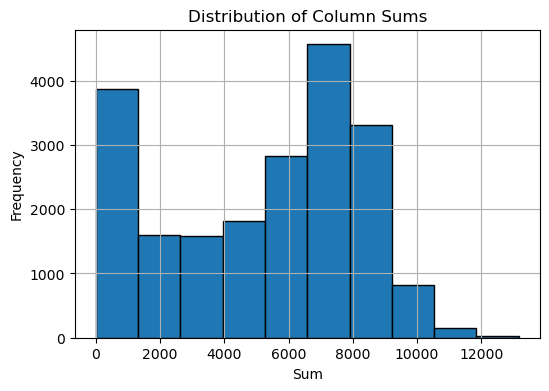

Quartile Ranges:
Q1 (25th percentile): 2354.2172488448955
Median (50th percentile): 6020.045465649453
Q3 (75th percentile): 7667.6631445153325
Interquartile Range (IQR): 5313.445895670437


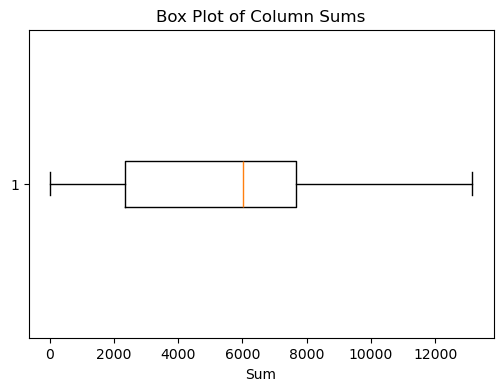

In [3]:
def examine_column_sums(merged_data):
    numeric_df = merged_data.select_dtypes(include=['number'])
    column_sums = numeric_df.sum()

    plt.figure(figsize=(6, 4))
    plt.hist(column_sums, bins=10, edgecolor='black')
    plt.title('Distribution of Column Sums')
    plt.xlabel('Sum')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    q1 = column_sums.quantile(0.25)
    q2 = column_sums.quantile(0.50)  
    q3 = column_sums.quantile(0.75)
    iqr = q3 - q1

    print("Quartile Ranges:")
    print(f"Q1 (25th percentile): {q1}")
    print(f"Median (50th percentile): {q2}")
    print(f"Q3 (75th percentile): {q3}")
    print(f"Interquartile Range (IQR): {iqr}")

    plt.figure(figsize=(6, 4))
    plt.boxplot(column_sums, vert=False)
    plt.title('Box Plot of Column Sums')
    plt.xlabel('Sum')
    plt.show()

    return column_sums

column_sums = examine_column_sums(merged_data=merged_data)

In [4]:
print("Columns that sum to zero:")
filtered_columns = column_sums[column_sums == 0]
# print(filtered_columns)
print("Number of features that are all zeroes:", len(filtered_columns))

Columns that sum to zero:
Number of features that are all zeroes: 267


There are a substantial number (267) of genes who show zero activation across all subjects, so we drop these from our analysis. We add this to our preprocessor. 

In [5]:
merged_data = merged_data.drop(columns = filtered_columns.index)
data = data.drop(columns = filtered_columns.index)
merged_data.head()

,sample_id,Class,gene_0,gene_1,gene_2,gene_3,gene_4,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,4,0.0,2.017209,3.265527,5.478487,10.431999,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,3,0.0,0.592732,1.588421,7.586157,9.623011,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,4,0.0,3.511759,4.327199,6.881787,9.870730,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,4,0.0,3.663618,4.507649,6.659068,10.196184,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,0,0.0,2.655741,2.821547,6.539454,9.738265,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


We next examine how this change effects the distribution of sums of activations over patients.

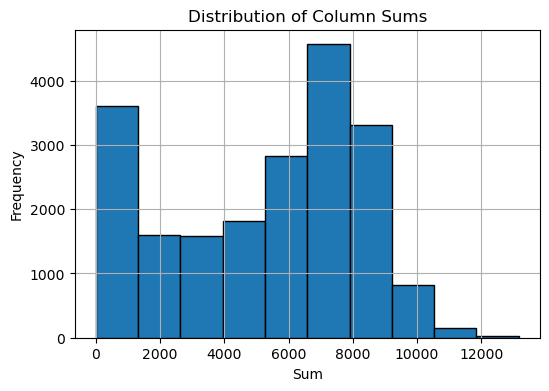

Quartile Ranges:
Q1 (25th percentile): 2524.952083249529
Median (50th percentile): 6085.5882221212
Q3 (75th percentile): 7682.594342943261
Interquartile Range (IQR): 5157.642259693732


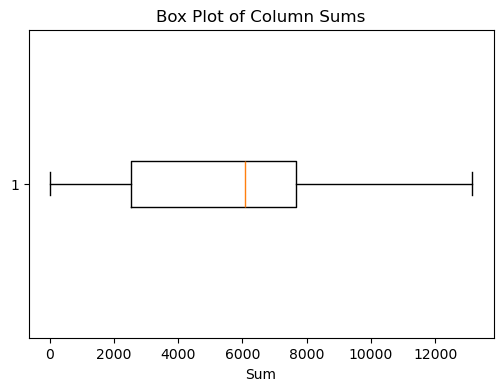

In [6]:
column_sums = examine_column_sums(merged_data=merged_data)

This change only has a small effect on the overall shape of the distribution.

We next examine the distribution of cancer labels across subjects.

/var/folders/20/l01njk_d68v9mcxb4mc_1c840000gn/T/ipykernel_6731/1315327273.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels['Class'], palette='viridis')


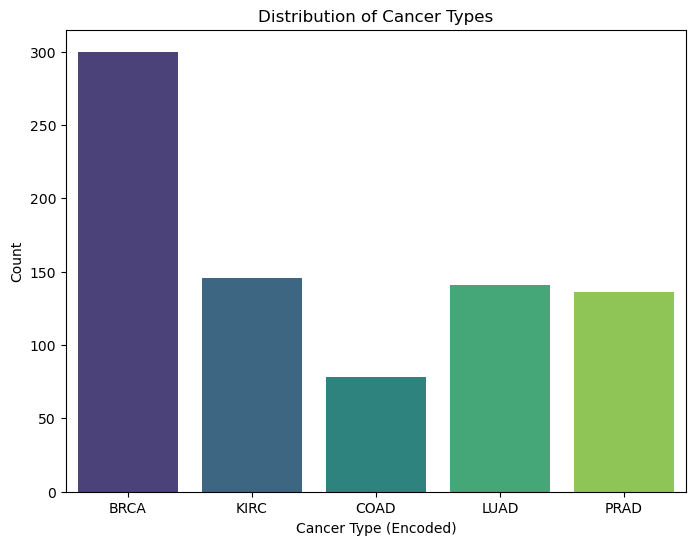

In [7]:
plt.figure(figsize=(8, 6))
sns.countplot(x=labels['Class'], palette='viridis')
plt.title('Distribution of Cancer Types')
plt.xlabel('Cancer Type (Encoded)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['BRCA', 'KIRC', 'COAD', 'LUAD', 'PRAD'])
plt.show()

Subjects with breast cancer (BRCA) appear most frequently in our dataset. Kidney (KIRC), lung (LUAD), and prostate (PRAD) cancer appear in similar frequencies. Subjects with colon cancer (COAD) appear least frequently.

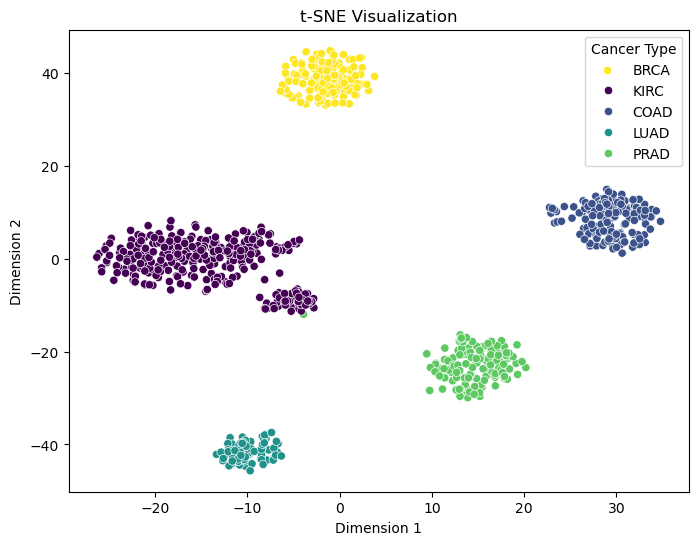

In [8]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
data_tsne = tsne.fit_transform(data)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_tsne[:, 0], y=data_tsne[:, 1], hue=labels['Class'], palette='viridis', legend='full')
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(title='Cancer Type', labels=['BRCA', 'KIRC', 'COAD', 'LUAD', 'PRAD'])
plt.show()

Using t-SNE Visualization, we can see that the data is distinctly clustered. From this we believe clustering algorithms will perform well for classification.

In fact, the clustering is so distinct that it is likely that the single PRAD datapoint in the KIRC cluster is an incorrect labelling. However, we decide to not treat this as an outlier, and instead leave it as-is in our analysis, as the apparent mislabelling may just be due to our low-dimension projection. 

## Conclusions

We decide to remove the all zero columns for our analysis.  